# Example 1: MNIST Classification with Transfer Learning

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import gc  # For garbage collection

# Set memory growth for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [15]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Use smaller subsets for training and testing
TRAIN_SAMPLES = 3000

Loading MNIST dataset...


In [16]:
TEST_SAMPLES = 500

x_train = x_train[:TRAIN_SAMPLES]
y_train = y_train[:TRAIN_SAMPLES]
x_test = x_test[:TEST_SAMPLES]
y_test = y_test[:TEST_SAMPLES]

In [17]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert grayscale images to RGB by repeating the same channel 3 times
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

# Use a smaller image size for transfer learning models
IMAGE_SIZE = 96
x_train_resized = np.zeros((x_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
x_test_resized = np.zeros((x_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

In [18]:

# Resize in batches to save memory
BATCH_SIZE = 100
for i in range(0, len(x_train), BATCH_SIZE):
    end = min(i + BATCH_SIZE, len(x_train))
    for j in range(i, end):
        x_train_resized[j] = tf.image.resize(x_train_rgb[j], (IMAGE_SIZE, IMAGE_SIZE))

for i in range(0, len(x_test), BATCH_SIZE):
    end = min(i + BATCH_SIZE, len(x_test))
    for j in range(i, end):
        x_test_resized[j] = tf.image.resize(x_test_rgb[j], (IMAGE_SIZE, IMAGE_SIZE))

print(f"Resized train data shape: {x_train_resized.shape}")
print(f"Resized test data shape: {x_test_resized.shape}")

Resized train data shape: (3000, 96, 96, 3)
Resized test data shape: (500, 96, 96, 3)


In [19]:
# Delete original arrays to free memory
del x_train, x_test, x_train_rgb, x_test_rgb
gc.collect()

# Convert labels to one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

### EfficientNet Transfer Learning

In [20]:
# Create a smaller version of EfficientNet
base_model_efficient = keras.applications.EfficientNetB0(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the base model
base_model_efficient.trainable = False

# Create a simple model using EfficientNet as the base
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model_efficient(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)
model_efficient = keras.Model(inputs, outputs)

# Compile the model
model_efficient.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model with EfficientNet
print("Training EfficientNet transfer learning model...")
history_efficient = model_efficient.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32,
    epochs=3,
    validation_data=(x_test_resized, y_test_one_hot),
)

Training EfficientNet transfer learning model...
Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.0984 - loss: 2.3590 - val_accuracy: 0.0900 - val_loss: 2.3338
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1048 - loss: 2.3432 - val_accuracy: 0.1100 - val_loss: 2.3142
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1034 - loss: 2.3335 - val_accuracy: 0.0860 - val_loss: 2.3192


In [21]:
# Evaluate the model
print("Evaluating EfficientNet model...")
results_efficient = model_efficient.evaluate(x_test_resized, y_test_one_hot)
print(f"EfficientNet Test Loss: {results_efficient[0]:.4f}")
print(f"EfficientNet Test Accuracy: {results_efficient[1]:.4f}")

# Clear the model to free memory
del model_efficient
gc.collect()
keras.backend.clear_session()

Evaluating EfficientNet model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0877 - loss: 2.3130
EfficientNet Test Loss: 2.3192
EfficientNet Test Accuracy: 0.0860


In [22]:
# BiT-like model (using ResNetV2)

# For BiT, we'll use ResNet50V2 as a substitute for demonstration purposes
base_model_bit = keras.applications.ResNet50V2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the base model
base_model_bit.trainable = False

# Create a model using ResNet50V2 as the base
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model_bit(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)
model_bit = keras.Model(inputs, outputs)

# Compile the model
model_bit.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model with BiT
print("Training BiT (ResNet50V2) transfer learning model...")
history_bit = model_bit.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32,
    epochs=3,
    validation_data=(x_test_resized, y_test_one_hot),
)

# Evaluate the model
print("Evaluating BiT (ResNet50V2) model...")
results_bit = model_bit.evaluate(x_test_resized, y_test_one_hot)
print(f"BiT Test Loss: {results_bit[0]:.4f}")
print(f"BiT Test Accuracy: {results_bit[1]:.4f}")

Training BiT (ResNet50V2) transfer learning model...
Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5568 - loss: 1.4665 - val_accuracy: 0.8500 - val_loss: 0.5057
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8567 - loss: 0.4477 - val_accuracy: 0.8680 - val_loss: 0.3778
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9156 - loss: 0.2782 - val_accuracy: 0.9000 - val_loss: 0.3038
Evaluating BiT (ResNet50V2) model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9023 - loss: 0.2991
BiT Test Loss: 0.3038
BiT Test Accuracy: 0.9000


In [23]:
# Plot training history for both models
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

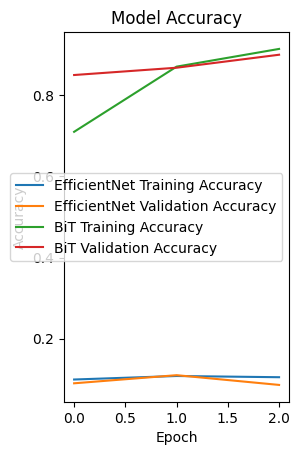

In [24]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficient.history['accuracy'], label='EfficientNet Training Accuracy')
plt.plot(history_efficient.history['val_accuracy'], label='EfficientNet Validation Accuracy')
plt.plot(history_bit.history['accuracy'], label='BiT Training Accuracy')
plt.plot(history_bit.history['val_accuracy'], label='BiT Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

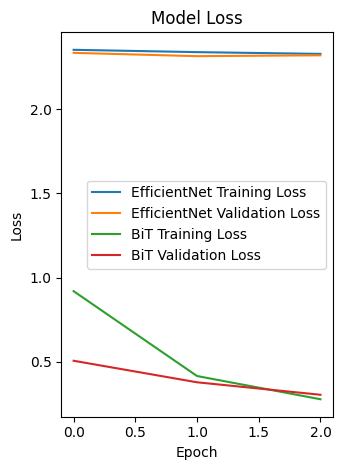

In [25]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_efficient.history['loss'], label='EfficientNet Training Loss')
plt.plot(history_efficient.history['val_loss'], label='EfficientNet Validation Loss')
plt.plot(history_bit.history['loss'], label='BiT Training Loss')
plt.plot(history_bit.history['val_loss'], label='BiT Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


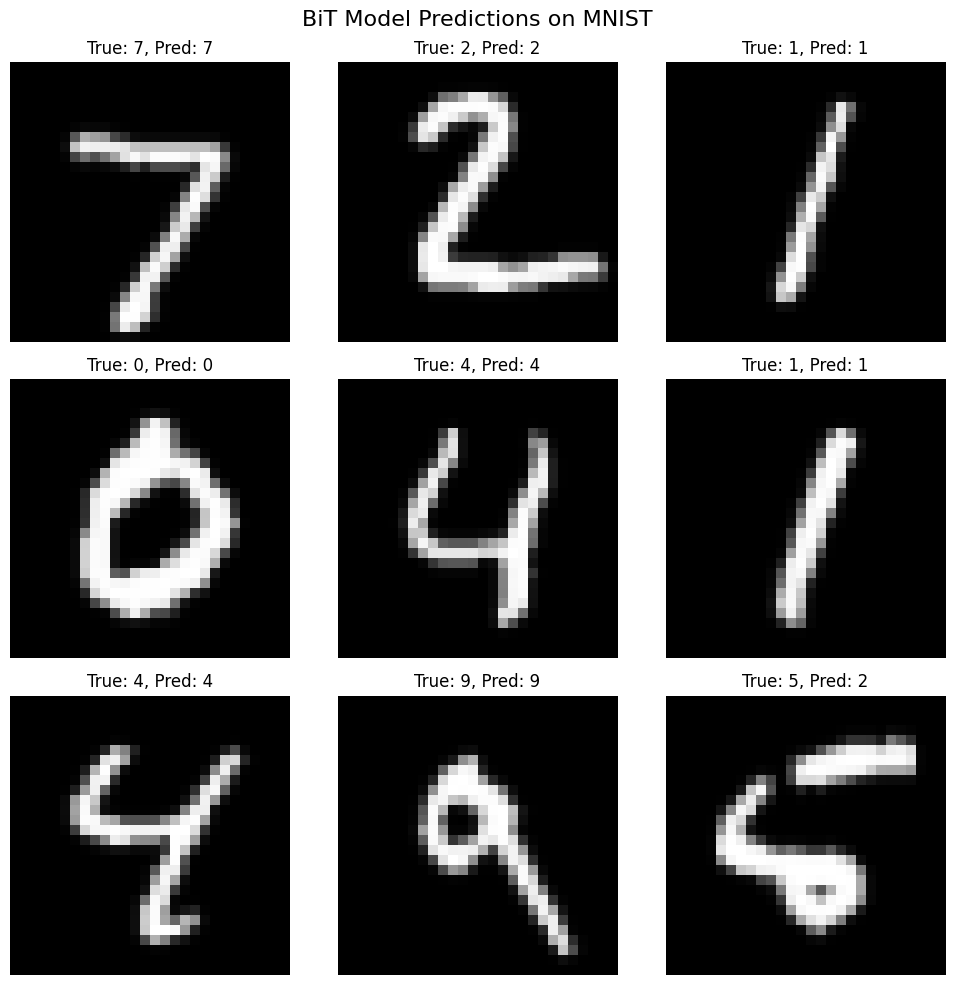

MNIST transfer learning demonstration complete!


In [26]:
# Generate predictions for visualization
predictions = model_bit.predict(x_test_resized[:9])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test[:9]

# Visualize some predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.image.resize(x_test_resized[i], (28, 28))[..., 0], cmap='gray')
    plt.title(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
    plt.axis('off')
plt.suptitle("BiT Model Predictions on MNIST", fontsize=16)
plt.tight_layout()
plt.show()

print("MNIST transfer learning demonstration complete!")

# Example 2: Fashion MNIST Classification with Transfer Learning

Loading Fashion MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


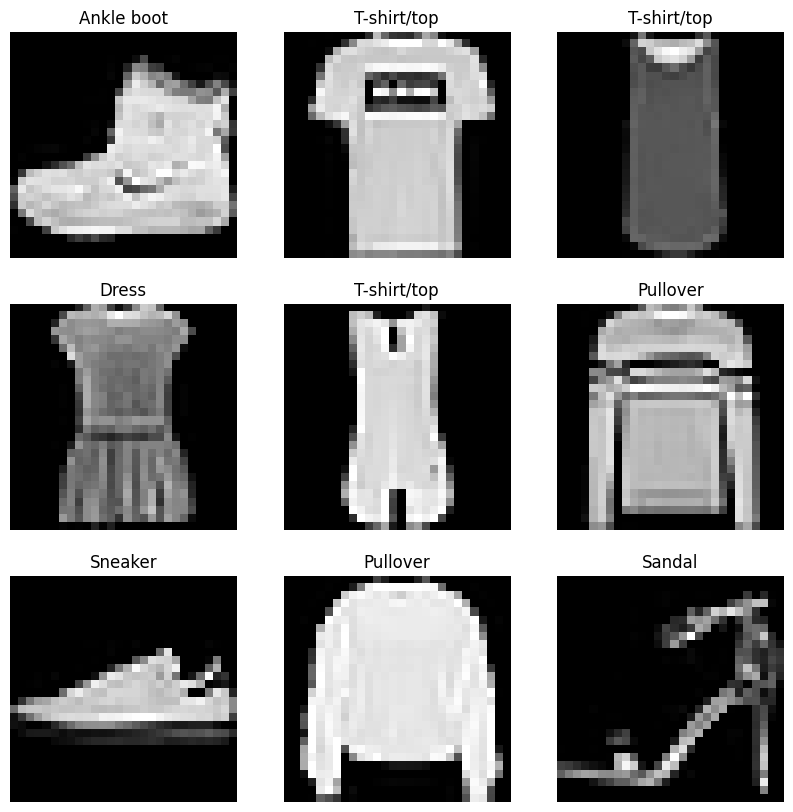

Preprocessing data...
Resized train data shape: (3000, 96, 96, 3)
Resized test data shape: (500, 96, 96, 3)

--- EfficientNet Transfer Learning ---
Training EfficientNet transfer learning model...
Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.0958 - loss: 2.3352 - val_accuracy: 0.1040 - val_loss: 2.3026
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1044 - loss: 2.3025 - val_accuracy: 0.1040 - val_loss: 2.3029
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1018 - loss: 2.3025 - val_accuracy: 0.1040 - val_loss: 2.3031
Evaluating EfficientNet model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1180 - loss: 2.3024
EfficientNet Test Loss: 2.3031
EfficientNet Test Accuracy: 0.1040

--- Fine-tuning EfficientNet ---
Epoch 1/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.1090 - loss: 2.5335 - val_accuracy: 0.1040 - val_loss: 2.3031
Epoch 2/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.0951 - loss: 2.4342 - val_

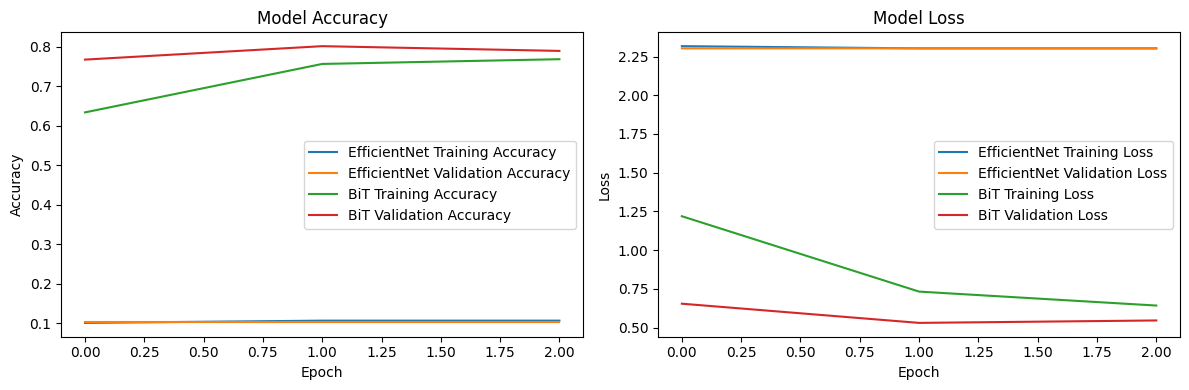

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


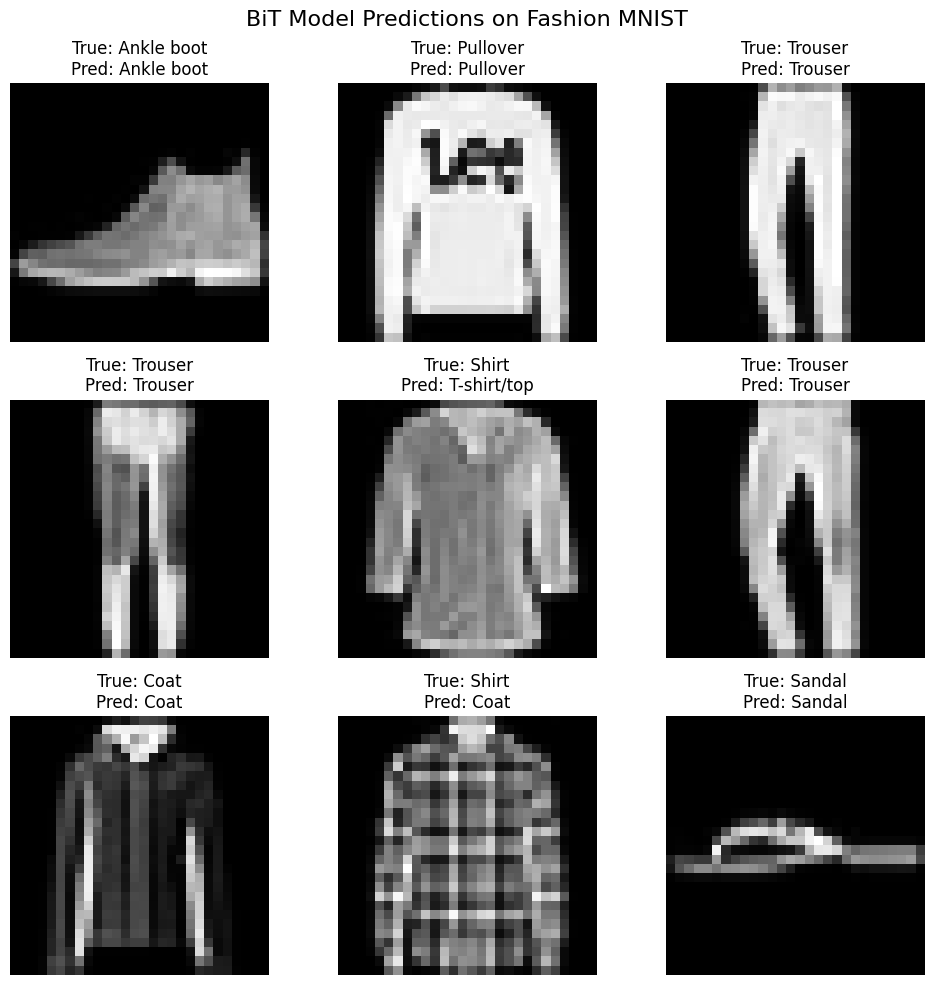

Fashion MNIST transfer learning demonstration complete!


In [27]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import gc  # For garbage collection

# Set memory growth for GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Load Fashion MNIST dataset
print("Loading Fashion MNIST dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Define class names for visualization
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Use smaller subsets for training and testing
TRAIN_SAMPLES = 3000
TEST_SAMPLES = 500

x_train = x_train[:TRAIN_SAMPLES]
y_train = y_train[:TRAIN_SAMPLES]
x_test = x_test[:TEST_SAMPLES]
y_test = y_test[:TEST_SAMPLES]

# Display some training images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.show()

# Preprocess data
print("Preprocessing data...")
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert grayscale images to RGB by repeating the same channel 3 times
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

# Use a smaller image size for transfer learning models
IMAGE_SIZE = 96
x_train_resized = np.zeros((x_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
x_test_resized = np.zeros((x_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

# Resize in batches to save memory
BATCH_SIZE = 100
for i in range(0, len(x_train), BATCH_SIZE):
    end = min(i + BATCH_SIZE, len(x_train))
    for j in range(i, end):
        x_train_resized[j] = tf.image.resize(x_train_rgb[j], (IMAGE_SIZE, IMAGE_SIZE))

for i in range(0, len(x_test), BATCH_SIZE):
    end = min(i + BATCH_SIZE, len(x_test))
    for j in range(i, end):
        x_test_resized[j] = tf.image.resize(x_test_rgb[j], (IMAGE_SIZE, IMAGE_SIZE))

print(f"Resized train data shape: {x_train_resized.shape}")
print(f"Resized test data shape: {x_test_resized.shape}")

# Delete original arrays to free memory
del x_train, x_test, x_train_rgb, x_test_rgb
gc.collect()

# Convert labels to one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

# Create data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
])

# EfficientNet Transfer Learning
print("\n--- EfficientNet Transfer Learning ---")

# Create a model using EfficientNetB0
base_model_efficient = keras.applications.EfficientNetB0(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the base model
base_model_efficient.trainable = False

# Create a model for Fashion MNIST using EfficientNet as the base
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = data_augmentation(inputs)  # Apply data augmentation
x = base_model_efficient(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)
model_efficient = keras.Model(inputs, outputs)

# Compile the model
model_efficient.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model with EfficientNet
print("Training EfficientNet transfer learning model...")
history_efficient = model_efficient.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32,
    epochs=3,
    validation_data=(x_test_resized, y_test_one_hot),
)

# Evaluate the model
print("Evaluating EfficientNet model...")
results_efficient = model_efficient.evaluate(x_test_resized, y_test_one_hot)
print(f"EfficientNet Test Loss: {results_efficient[0]:.4f}")
print(f"EfficientNet Test Accuracy: {results_efficient[1]:.4f}")

# Fine-tuning: Let's unfreeze some layers in EfficientNet and fine-tune
print("\n--- Fine-tuning EfficientNet ---")

# Unfreeze only the top few layers of the EfficientNet model
for layer in base_model_efficient.layers[-10:]:
    layer.trainable = True

# Recompile model with a lower learning rate for fine-tuning
model_efficient.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Much lower learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
history_fine_tune = model_efficient.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32,
    epochs=2,  # Fewer epochs for fine-tuning
    validation_data=(x_test_resized, y_test_one_hot),
)

# Evaluate the fine-tuned model
print("Evaluating fine-tuned EfficientNet model...")
results_fine_tune = model_efficient.evaluate(x_test_resized, y_test_one_hot)
print(f"Fine-tuned EfficientNet Test Loss: {results_fine_tune[0]:.4f}")
print(f"Fine-tuned EfficientNet Test Accuracy: {results_fine_tune[1]:.4f}")

# Save the EfficientNet model results
eff_train_acc = history_efficient.history['accuracy']
eff_val_acc = history_efficient.history['val_accuracy']
eff_train_loss = history_efficient.history['loss']
eff_val_loss = history_efficient.history['val_loss']

# Clear model to free memory
del model_efficient, base_model_efficient
gc.collect()
keras.backend.clear_session()

# BiT-like model (using ResNetV2)
print("\n--- BiT (Big Transfer) Model ---")

# For BiT, we'll use ResNet50V2 as a substitute
base_model_bit = keras.applications.ResNet50V2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the base model
base_model_bit.trainable = False

# Create a model for Fashion MNIST using "BiT" as the base
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = data_augmentation(inputs)  # Apply data augmentation
x = base_model_bit(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)
model_bit = keras.Model(inputs, outputs)

# Compile the model
model_bit.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model with BiT
print("Training BiT transfer learning model...")
history_bit = model_bit.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32,
    epochs=3,
    validation_data=(x_test_resized, y_test_one_hot),
)

# Evaluate the model
print("Evaluating BiT model...")
results_bit = model_bit.evaluate(x_test_resized, y_test_one_hot)
print(f"BiT Test Loss: {results_bit[0]:.4f}")
print(f"BiT Test Accuracy: {results_bit[1]:.4f}")

# Plot training history for both models
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(eff_train_acc, label='EfficientNet Training Accuracy')
plt.plot(eff_val_acc, label='EfficientNet Validation Accuracy')
plt.plot(history_bit.history['accuracy'], label='BiT Training Accuracy')
plt.plot(history_bit.history['val_accuracy'], label='BiT Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(eff_train_loss, label='EfficientNet Training Loss')
plt.plot(eff_val_loss, label='EfficientNet Validation Loss')
plt.plot(history_bit.history['loss'], label='BiT Training Loss')
plt.plot(history_bit.history['val_loss'], label='BiT Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions for visualization
predictions = model_bit.predict(x_test_resized[:9])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test[:9]

# Visualize some predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.image.resize(x_test_resized[i], (28, 28))[..., 0], cmap='gray')
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis('off')
plt.suptitle("BiT Model Predictions on Fashion MNIST", fontsize=16)
plt.tight_layout()
plt.show()

print("Fashion MNIST transfer learning demonstration complete!")

# Example 3: CIFAR-10 Classification with Transfer Learning

--- Initializing ---
GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth configured.
TensorFlow Version: 2.18.0
Timestamp: Sun May  4 03:46:55 2025
--------------------

--- Loading CIFAR-10 dataset ---
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Dataset loaded in 72.04 seconds.
Using 5000 training samples and 1000 test samples.
--------------------------------

--- Preprocessing data ---
Resizing images to 96x96...
Resized train data shape: (5000, 96, 96, 3)
Resized test data shape: (1000, 96, 96, 3)
Image resizing finished in 1.02 seconds.
Deleting original image arrays...
Labels converted to one-hot encoding.
--------------------------


--- EfficientNetB0 Transfer Learning ---
EfficientNetB0 base model loaded and frozen.
EfficientNet transfer model compiled.


Model: "EfficientNet_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training EfficientNet transfer learning model...
Epoch 1/5
157/157 - 18s - 114ms/step - accuracy: 0.1064 - loss: 2.3370 - val_accuracy: 0.1090 - val_loss: 2.3257
Epoch 2/5
157/157 - 4s - 28ms/step - accuracy: 0.0968 - loss: 2.3395 - val_accuracy: 0.1120 - val_loss: 2.3344
Epoch 3/5
157/157 - 4s - 23ms/step - accuracy: 0.0958 - loss: 2.3387 - val_accuracy: 0.1130 - val_loss: 2.3149
Epoch 4/5
157/157 - 4s - 24ms/step - accuracy: 0.0978 - loss: 2.3379 - val_accuracy: 0.1030 - val_loss: 2.3243
Epoch 5/5
157/157 - 5s - 34ms/step - accuracy: 0.0972 - loss: 2.3356 - val_accuracy: 0.1030 - val_loss: 2.3417
EfficientNet training finished in 37.31 seconds.
Evaluating EfficientNet model...
EfficientNet Test Loss: 2.3417
EfficientNet Test Accuracy: 0.1030
--------------------------------------


--- Fine-tuning EfficientNet ---
Unfreezing base model from layer 119 onwards.
Recompiled model for fine-tuning.
Fine-tuning EfficientNet model...
Epoch 6/8
157/157 - 39s - 248ms/step - accuracy: 0.1226 - 

Model: "BiT_ResNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 3, 3, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,828,362 (90.90 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Training BiT (ResNet50V2) transfer learning model...
Epoch 1/5
157/157 - 16s - 102ms/step - accuracy: 0.1228 - loss: 2.3057 - val_accuracy: 0.1470 - val_loss: 2.2604
Epoch 2/5
157/157 - 5s - 33ms/step - accuracy: 0.1658 - loss: 2.2286 - val_accuracy: 0.2240 - val_loss: 2.1802
Epoch 3/5
157/157 - 11s - 69ms/step - accuracy: 0.1866 - loss: 2.1829 - val_accuracy: 0.2410 - val_loss: 2.1453
Epoch 4/5
157/157 - 6s - 36ms/step - accuracy: 0.2054 - loss: 2.1356 - val_accuracy: 0.2710 - val_loss: 2.0779
Epoch 5/5
157/157 - 5s - 34ms/step - accuracy: 0.2156 - loss: 2.1137 - val_accuracy: 0.2510 - val_loss: 2.0647
BiT (ResNetV2) training finished in 49.21 seconds.
Evaluating BiT (ResNetV2) model...
BiT (ResNetV2) Test Loss: 2.0647
BiT (ResNetV2) Test Accuracy: 0.2510
-----------------------------------------------------


--- Plotting Model Comparison ---


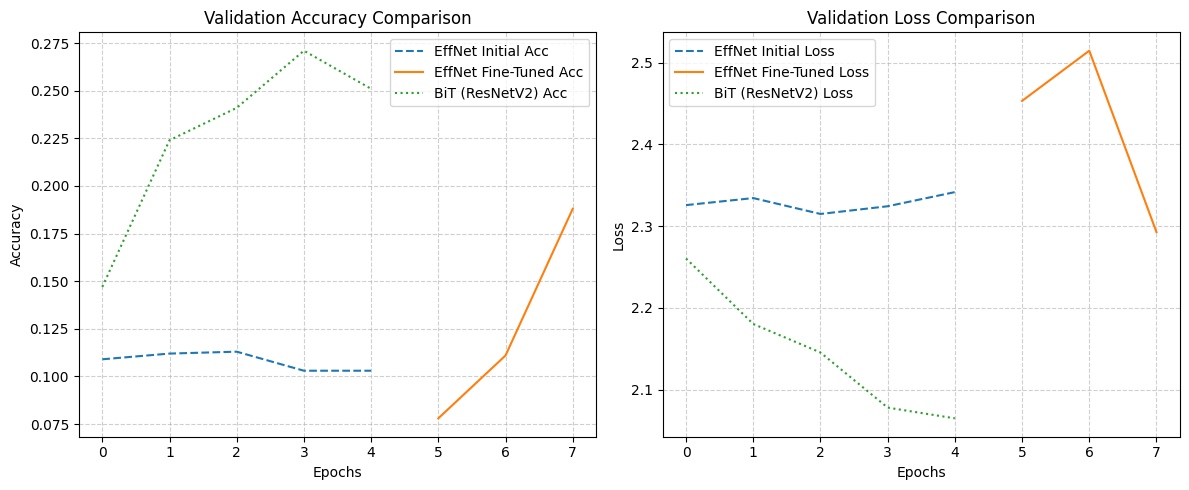

---------------------------------

Deleting BiT (ResNetV2) models to free memory...
Cleanup complete.

--- End of Script ---


In [28]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import gc  # For garbage collection
import time # For timing

# Set memory growth for GPU if available
print("--- Initializing ---")
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU(s) available: {physical_devices}")
        print("GPU memory growth configured.")
    except RuntimeError as e:
         print(f"Could not set memory growth, error: {e}")
else:
    print("No GPU detected. Running on CPU.")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Timestamp: {time.ctime()}")
print("--------------------\n")


# Load CIFAR-10 dataset
print("--- Loading CIFAR-10 dataset ---")
start_time = time.time()
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"Dataset loaded in {time.time() - start_time:.2f} seconds.")

# Define class names for visualization
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Use smaller subsets for training and testing
TRAIN_SAMPLES = 5000
TEST_SAMPLES = 1000

x_train = x_train[:TRAIN_SAMPLES]
y_train = y_train[:TRAIN_SAMPLES]
x_test = x_test[:TEST_SAMPLES]
y_test = y_test[:TEST_SAMPLES]
print(f"Using {TRAIN_SAMPLES} training samples and {TEST_SAMPLES} test samples.")
print("--------------------------------\n")

# Display some training images (Optional)
# plt.figure(figsize=(10, 10))
# plt.suptitle("Sample Training Images")
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(x_train[i])
#     plt.title(class_names[y_train[i][0]])
#     plt.axis("off")
# plt.show()

# Preprocess data
print("--- Preprocessing data ---")
start_time = time.time()
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# CIFAR-10 images are already RGB, but we need to resize them for the transfer learning models
IMAGE_SIZE = 96  # Using a smaller image size than standard 224 to save memory/speed up demo
print(f"Resizing images to {IMAGE_SIZE}x{IMAGE_SIZE}...")

# Pre-allocate numpy arrays - might fail if IMAGE_SIZE and TRAIN/TEST_SAMPLES are large
try:
    x_train_resized = np.zeros((x_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    x_test_resized = np.zeros((x_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
except MemoryError:
    print("ERROR: Could not allocate memory for resized images. Try reducing IMAGE_SIZE or sample counts.")
    # Exit or handle error appropriately
    exit()


# Resize using tf.image.resize (can be faster than loops if vectorized, but loop avoids loading all at once)
# Using tf.data is generally preferred, but let's stick to the provided loop structure for memory safety focus
# Note: This loop might be slow in Python. tf.data.Dataset.map is much faster.
resize_batch_size = 256 # Process resizing in smaller batches
for i in range(0, len(x_train), resize_batch_size):
    batch = x_train[i:min(i + resize_batch_size, len(x_train))]
    resized_batch = tf.image.resize(batch, (IMAGE_SIZE, IMAGE_SIZE))
    x_train_resized[i:i+resized_batch.shape[0]] = resized_batch.numpy() # Use numpy() to assign

for i in range(0, len(x_test), resize_batch_size):
    batch = x_test[i:min(i + resize_batch_size, len(x_test))]
    resized_batch = tf.image.resize(batch, (IMAGE_SIZE, IMAGE_SIZE))
    x_test_resized[i:i+resized_batch.shape[0]] = resized_batch.numpy() # Use numpy() to assign

print(f"Resized train data shape: {x_train_resized.shape}")
print(f"Resized test data shape: {x_test_resized.shape}")
print(f"Image resizing finished in {time.time() - start_time:.2f} seconds.")

# Delete original arrays to free memory
print("Deleting original image arrays...")
del x_train, x_test
gc.collect()

# Convert labels to one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)
print("Labels converted to one-hot encoding.")
print("--------------------------\n")

# Create data augmentation layer for improved training
data_augmentation = keras.Sequential([
    keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)), # Explicit Input shape for augmentation layer
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1), # Added zoom
], name="data_augmentation")


# === EfficientNet Transfer Learning ===
print("\n--- EfficientNetB0 Transfer Learning ---")
model_histories = {} # Dictionary to store histories

# Load the EfficientNetB0 model pre-trained on ImageNet
base_model_efficient = keras.applications.EfficientNetB0(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False, # Don't include ImageNet classifier head
    weights="imagenet"
)

# Freeze the base model
base_model_efficient.trainable = False
print("EfficientNetB0 base model loaded and frozen.")

# Create a model for CIFAR-10 using EfficientNet as the base
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input_image')
x = data_augmentation(inputs)  # Apply data augmentation first
x = keras.applications.efficientnet.preprocess_input(x)  # Preprocess inputs for EfficientNet
x = base_model_efficient(x, training=False) # Ensure base runs in inference mode
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = keras.layers.Dropout(0.2, name='top_dropout')(x)
outputs = keras.layers.Dense(10, activation="softmax", name='prediction')(x)
model_efficient = keras.Model(inputs, outputs, name='EfficientNet_Transfer')

# Compile the model
model_efficient.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy", # Use categorical since labels are one-hot
    metrics=["accuracy"]
)
print("EfficientNet transfer model compiled.")
model_efficient.summary()

# Train the model with EfficientNet
print("Training EfficientNet transfer learning model...")
start_time = time.time()
eff_epochs = 5
history_efficient = model_efficient.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32, # Smaller batch size for training
    epochs=eff_epochs,
    validation_data=(x_test_resized, y_test_one_hot),
    verbose=2 # Use verbose=2 for less output per epoch
)
print(f"EfficientNet training finished in {time.time() - start_time:.2f} seconds.")
model_histories['EfficientNet_Initial'] = history_efficient.history # Store history

# Evaluate the model
print("Evaluating EfficientNet model...")
results_efficient = model_efficient.evaluate(x_test_resized, y_test_one_hot, verbose=0)
print(f"EfficientNet Test Loss: {results_efficient[0]:.4f}")
print(f"EfficientNet Test Accuracy: {results_efficient[1]:.4f}")
print("--------------------------------------\n")


# === Fine-tuning EfficientNet ===
print("\n--- Fine-tuning EfficientNet ---")

# Unfreeze some layers of the base model
# Unfreeze the top layers (e.g., last block) of the EfficientNet model
base_model_efficient.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model_efficient.layers) // 2 # Example: Unfreeze half
print(f"Unfreezing base model from layer {fine_tune_at} onwards.")
for layer in base_model_efficient.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile model with a lower learning rate for fine-tuning
model_efficient.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Much lower learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
print("Recompiled model for fine-tuning.")
# model_efficient.summary() # Check trainable params

# Fine-tune the model
print("Fine-tuning EfficientNet model...")
start_time = time.time()
fine_tune_epochs = 3
total_epochs = eff_epochs + fine_tune_epochs

history_fine_tune = model_efficient.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32,
    epochs=total_epochs, # Train for total epochs
    initial_epoch=history_efficient.epoch[-1] + 1, # Start from where previous training stopped
    validation_data=(x_test_resized, y_test_one_hot),
    verbose=2
)
print(f"EfficientNet fine-tuning finished in {time.time() - start_time:.2f} seconds.")
model_histories['EfficientNet_FineTuned'] = history_fine_tune.history # Store history

# Evaluate the fine-tuned model
print("Evaluating fine-tuned EfficientNet model...")
results_fine_tune = model_efficient.evaluate(x_test_resized, y_test_one_hot, verbose=0)
print(f"Fine-tuned EfficientNet Test Loss: {results_fine_tune[0]:.4f}")
print(f"Fine-tuned EfficientNet Test Accuracy: {results_fine_tune[1]:.4f}")

# Clean up EfficientNet model
print("Deleting EfficientNet models to free memory...")
del model_efficient, base_model_efficient, history_efficient, history_fine_tune
gc.collect()
keras.backend.clear_session() # Clear Keras session
print("------------------------------\n")


# === BiT (ResNet50V2) Transfer Learning ===
print("\n--- BiT (Simulated with ResNet50V2) Transfer Learning ---")

# Load ResNet50V2 as a stand-in for BiT
base_model_bit = keras.applications.ResNet50V2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the base model
base_model_bit.trainable = False
print("ResNet50V2 base model loaded and frozen.")

# Create a model for CIFAR-10 using "BiT" (ResNet50V2) as the base
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input_image')
x = data_augmentation(inputs)  # Apply data augmentation
x = keras.applications.resnet_v2.preprocess_input(x)  # Preprocess inputs for ResNetV2
x = base_model_bit(x, training=False) # Run base in inference mode
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = keras.layers.Dense(128, activation="relu", name='dense_hidden')(x) # Added intermediate Dense
x = keras.layers.Dropout(0.3, name='top_dropout')(x) # Increased dropout slightly
outputs = keras.layers.Dense(10, activation="softmax", name='prediction')(x)
model_bit = keras.Model(inputs, outputs, name='BiT_ResNetV2_Transfer')

# Compile the model
model_bit.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
print("BiT (ResNetV2) transfer model compiled.")
model_bit.summary()

# Train the model with BiT (ResNet50V2)
print("Training BiT (ResNet50V2) transfer learning model...")
start_time = time.time()
bit_epochs = 5
history_bit = model_bit.fit(
    x_train_resized,
    y_train_one_hot,
    batch_size=32,
    epochs=bit_epochs,
    validation_data=(x_test_resized, y_test_one_hot), # <<< COMPLETED THIS LINE
    verbose=2
) # <<< COMPLETED THIS LINE
print(f"BiT (ResNetV2) training finished in {time.time() - start_time:.2f} seconds.")
model_histories['BiT_ResNet50V2'] = history_bit.history # Store history


# === Evaluate BiT (ResNet50V2) Model ===  # <<< ADDED THIS SECTION
print("Evaluating BiT (ResNetV2) model...")
results_bit = model_bit.evaluate(x_test_resized, y_test_one_hot, verbose=0)
print(f"BiT (ResNetV2) Test Loss: {results_bit[0]:.4f}")
print(f"BiT (ResNetV2) Test Accuracy: {results_bit[1]:.4f}")
print("-----------------------------------------------------\n")


# === Plotting Comparison === # <<< ADDED THIS SECTION
print("\n--- Plotting Model Comparison ---")

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.title('Validation Accuracy Comparison')
# Plot EfficientNet Initial History
if 'EfficientNet_Initial' in model_histories:
    plt.plot(model_histories['EfficientNet_Initial']['val_accuracy'], label='EffNet Initial Acc', linestyle='--')
# Plot EfficientNet Fine-tuned History (adjust epoch numbers)
if 'EfficientNet_FineTuned' in model_histories:
     # Combine epochs for plotting fine-tuning correctly
    initial_epochs_eff = len(model_histories['EfficientNet_Initial']['val_accuracy'])
    fine_tune_epochs_range = range(initial_epochs_eff, initial_epochs_eff + len(model_histories['EfficientNet_FineTuned']['val_accuracy']))
    plt.plot(fine_tune_epochs_range, model_histories['EfficientNet_FineTuned']['val_accuracy'], label='EffNet Fine-Tuned Acc')
# Plot BiT History
if 'BiT_ResNet50V2' in model_histories:
    plt.plot(model_histories['BiT_ResNet50V2']['val_accuracy'], label='BiT (ResNetV2) Acc', linestyle=':')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Validation Loss Comparison')
if 'EfficientNet_Initial' in model_histories:
    plt.plot(model_histories['EfficientNet_Initial']['val_loss'], label='EffNet Initial Loss', linestyle='--')
if 'EfficientNet_FineTuned' in model_histories:
    initial_epochs_eff = len(model_histories['EfficientNet_Initial']['val_loss'])
    fine_tune_epochs_range = range(initial_epochs_eff, initial_epochs_eff + len(model_histories['EfficientNet_FineTuned']['val_loss']))
    plt.plot(fine_tune_epochs_range, model_histories['EfficientNet_FineTuned']['val_loss'], label='EffNet Fine-Tuned Loss')
if 'BiT_ResNet50V2' in model_histories:
    plt.plot(model_histories['BiT_ResNet50V2']['val_loss'], label='BiT (ResNetV2) Loss', linestyle=':')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
print("---------------------------------\n")


# === Cleanup === # <<< ADDED THIS SECTION
print("Deleting BiT (ResNetV2) models to free memory...")
del model_bit, base_model_bit, history_bit
del x_train_resized, y_train_one_hot, x_test_resized, y_test_one_hot # Delete data arrays
gc.collect()
keras.backend.clear_session() # Clear Keras session
print("Cleanup complete.")


print("\n--- End of Script ---")